All analysis is being done in hg38

# The goal of this script is categorize common SNPs into 6 different categories:

 1. SNPs found in splice sites
 2. SNPs creating new splice sites
 3. SNPs found in ISRE motifs
 4. SNPs creating new ISRE motifs
 5. SNPs flanking a certain distance from ISRE motifs
 6. SNPs that don't meet any of the above criteria

In [3]:
# Import relevant packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import regex as re2
import seaborn as sns

In [4]:
chrom = range(1,23)
chrom.extend(['X','Y'])
chrom_act = ['chr'+str(i) for i in chrom]

In [5]:
whichDataSet="CommonSNPs"

We want to look at the distribution of SNPs along the introns. We intersect SNPs with the introns

In [5]:
%%script bash
DataSet="CommonSNPs"
bedtools intersect -a ../processed_data/Introns_JustmRNAs.bed -b ../processed_data/commonSNPs_all_processed_AboveMAF5Percent.bed -wa -wb > ../temp/${DataSet}/Introns_Intersect_${DataSet}.txt

In [6]:
# Read in the SNPs that intersect
introns_Intersect_SNPs = pd.read_csv("../temp/"+whichDataSet+"/Introns_Intersect_"+whichDataSet+".txt",sep="\t",header=None)
print introns_Intersect_SNPs.shape
introns_Intersect_SNPs.head()

(6246512, 13)


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,chr1,67093604,67096251,NM_001276352,-,C1orf141,chr1,67093925,67093926,rs28721308,G,A,0.1162
1,chr1,67093604,67096251,NM_001276352,-,C1orf141,chr1,67094056,67094057,rs11800698,G,A,0.1162
2,chr1,67093604,67096251,NM_001276352,-,C1orf141,chr1,67094062,67094063,rs11807091,C,T,0.1124
3,chr1,67093604,67096251,NM_001276352,-,C1orf141,chr1,67094245,67094246,rs6679223,G,A,0.6228
4,chr1,67093604,67096251,NM_001276352,-,C1orf141,chr1,67094401,67094402,rs72933963,A,G,0.1162


In [7]:
# Now SNPs can overlap a few introns, especially if these introns are alternatively spliced
# Our approach is to just randomly select one intron the SNP overlaps with
# First we group by the SNP ID
introns_Intersect_SNPs_SingleLocation = introns_Intersect_SNPs.groupby([9]).apply(lambda x :x.iloc[np.random.randint(0, len(x))])
print introns_Intersect_SNPs_SingleLocation.shape
introns_Intersect_SNPs_SingleLocation.head()

(2548059, 13)


,0,1,2,3,4,5,6,7,8,9,10,11,12
9,,,,,,,,,,,,,
rs10000000,chr4,40073551,40097226,NM_001318359,+,N4BP2,chr4,40087275,40087276,rs10000000,A,T,0.16990
rs10000006,chr4,107903386,107908564,NM_001136258,+,SGMS2,chr4,107905226,107905227,rs10000006,T,C,0.21210
rs10000007,chr4,113609206,113661712,NM_172127,-,CAMK2D,chr4,113632096,113632097,rs10000007,A,C,0.12140
rs10000008,chr4,171814718,172229655,NM_001034845,+,GALNTL6,chr4,171855052,171855053,rs10000008,C,T,0.09225
rs10000010,chr4,20850667,21697349,NM_001035003,-,KCNIP4,chr4,21617050,21617051,rs10000010,T,C,0.57170


In [8]:
introns_Intersect_SNPs_SingleLocation_sorted = introns_Intersect_SNPs_SingleLocation.sort_values(by=[0,1,2])
introns_Intersect_SNPs_SingleLocation_sorted.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
9,,,,,,,,,,,,,
rs115239915,chr1,926013,930154,NM_152486,+,SAMD11,chr1,927302,927303,rs115239915,G,A,0.05351
rs13302982,chr1,926013,930154,NM_152486,+,SAMD11,chr1,926427,926428,rs13302982,A,G,0.68230
rs13303101,chr1,926013,930154,NM_152486,+,SAMD11,chr1,926743,926744,rs13303101,A,G,0.68270
rs1806501,chr1,926013,930154,NM_152486,+,SAMD11,chr1,928621,928622,rs1806501,G,C,0.16170
rs2340587,chr1,926013,930154,NM_152486,+,SAMD11,chr1,929557,929558,rs2340587,G,A,0.51260


In [9]:
introns_Intersect_SNPs_SingleLocation_sorted.to_csv("../temp/"+whichDataSet+"/introns_unique_Intersect_"+whichDataSet+".txt",sep="\t",header=False,index=False)

In [10]:
# This function will get the difference between start site of feature of interest and see how far it is from the start
# of the intron
def getDataForAnydistribution(data,window_5,window_3):
    data_plus = data[data[4]=='+']
    data_minus = data[data[4]=='-']
    valid_data_plus = data_plus[(data_plus[7] >= data_plus[1]+window_5) & (data_plus[7] <= data_plus[2]-1-window_3)]
    valid_data_minus = data_minus[(data_minus[7] >= data_minus[1]+window_3) & (data_minus[7] <= data_minus[2]-1-window_5)]
    data_dist_plus = (valid_data_plus[7]-valid_data_plus[1])/(valid_data_plus[2]-valid_data_plus[1])
    data_dist_minus = (valid_data_minus[7] - valid_data_minus[1]) / (valid_data_minus[2] - valid_data_minus[1])
    return pd.concat([data_dist_plus,1-data_dist_minus])

In [11]:
introns_Intersect_SNPs_SingleLocation = pd.read_csv("../temp/"+whichDataSet+"/introns_unique_Intersect_"+whichDataSet+".txt",header=None,sep="\t")
introns_SNPs_dist = getDataForAnydistribution(introns_Intersect_SNPs_SingleLocation,0,0)
introns_SNPs_dist.head()

0    0.311277
1    0.099976
2    0.176286
3    0.629800
4    0.855832
dtype: float64

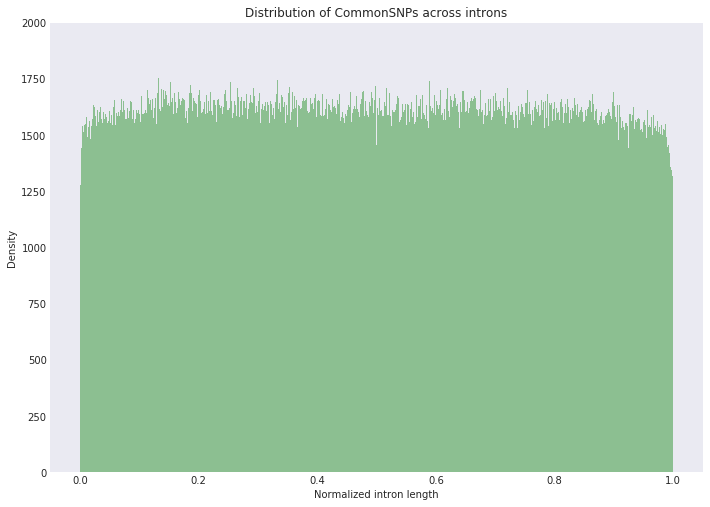

In [12]:
# Plot the distribution of SNPs across introns
# Number of bins are the equal to the median length of an intron 1582
sns.set_style("dark")
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.distplot(introns_SNPs_dist, bins=1582, kde=False, rug=False, color="green");
plt.ylim([0,2000])
plt.ylabel('Density')
plt.xlabel('Normalized intron length')
plt.title("Distribution of "+whichDataSet+" across introns")
plt.show()

In [13]:
# We want to take a look at the distribution of SNPs across introns but remove those that are within splice sites
# 5' splice site is 6 bases into intron, while 3' splice site is 34 bases into intron
introns_SNPs_dist_outsideSS = getDataForAnydistribution(introns_Intersect_SNPs_SingleLocation,6,34)
introns_SNPs_dist_outsideSS.head()

0    0.311277
1    0.099976
2    0.176286
3    0.629800
4    0.855832
dtype: float64

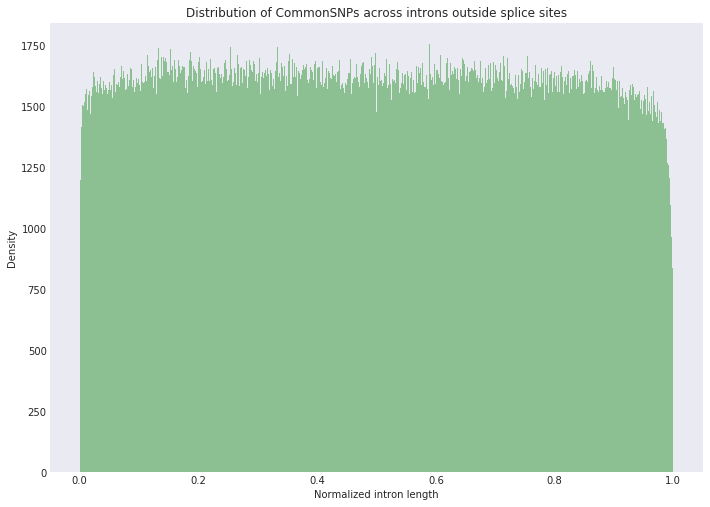

In [15]:
# Plot the distribution of SNPs across introns after removing those that are within Splice sites
# Number of bins are the equal to the median length of an intron 1582
sns.set_style("dark")
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.distplot(introns_SNPs_dist_outsideSS, bins=1582, kde=False, rug=False, color="green");
#plt.ylim([0,500])
plt.ylabel('Density')
plt.xlabel('Normalized intron length')
plt.title("Distribution of "+whichDataSet+" across introns outside splice sites")
plt.show()

### This will help us with the first category: SNPs found within splice sites.

We want to separate out SNPs that are within the 5' splice site and 3' splice site, polypyramidine sites, branch point. 

In [16]:
# This function will return a list that contains three elements. One with DAVs within  5' splice sites
# One with DAVs within 3' splice sites, and One with DAVs not within splice sites
def separateMutations(data):
    data_plus = data[data[4]=='+']
    data_plus_within5p = data_plus[data_plus[7] <= data_plus[1] + 6]
    data_plus_within3p = data_plus[data_plus[7] >= data_plus[2] - 33]
    data_plus_notwithinSS = data_plus[(data_plus[7] > data_plus[1] + 6)&(data_plus[7] < data_plus[2] - 33)]
    data_minus = data[data[4]=='-']
    data_minus_within3p = data_minus[data_minus[7] <= data_minus[1] + 34]
    data_minus_within5p = data_minus[data_minus[7] >= data_minus[2] - 5]
    data_minus_notwithinSS = data_minus[(data_minus[7] > data_minus[1] + 34)&(data_minus[7] < data_minus[2] - 5)]
    return([pd.concat([data_plus_within5p,data_minus_within5p]),pd.concat([data_plus_within3p,data_minus_within3p]),pd.concat([data_plus_notwithinSS,data_minus_notwithinSS])])

In [17]:
SNPs_Intersect_Introns_WithinORnotSSs = separateMutations(introns_Intersect_SNPs_SingleLocation)

In [18]:
SNPs_Intersect_Introns_WithinORnotSSs[0].head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
272,chr1,1051815,1053752,NM_198576,+,AGRN,chr1,1051819,1051820,rs9803031,C,T,0.7887
394,chr1,1173926,1174284,NM_001130045,+,TTLL10,chr1,1173930,1173931,rs5010606,G,A,0.1368
1002,chr1,1522899,1523510,NM_018188,+,ATAD3A,chr1,1522904,1522905,rs6675874,A,G,0.3345
1003,chr1,1523567,1523838,NM_001170535,+,ATAD3A,chr1,1523573,1523574,rs3737714,C,T,0.2143
5581,chr1,3772841,3773062,NM_001163724,+,SMIM1,chr1,3772843,3772844,rs2275819,G,A,0.2332


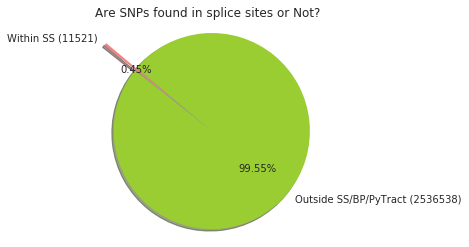

In [20]:
numSNPs_5SS_introns = SNPs_Intersect_Introns_WithinORnotSSs[0].shape[0]
numSNPs_3SS_introns = SNPs_Intersect_Introns_WithinORnotSSs[1].shape[0]
numSNPs_nonSS_introns = SNPs_Intersect_Introns_WithinORnotSSs[2].shape[0]

labels = 'Within SS (' + str(numSNPs_5SS_introns+numSNPs_3SS_introns) + ')', \
                'Outside SS/BP/PyTract (' + str(numSNPs_nonSS_introns) + ')'
sizes = [numSNPs_5SS_introns+numSNPs_3SS_introns,numSNPs_nonSS_introns]
colors = ['lightcoral','yellowgreen']
explode = (0,0.4)  # explode 1st slice
 
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.2f%%', shadow=True, startangle=140)
plt.title('Are SNPs found in splice sites or Not?')
plt.axis('equal')
plt.show()

In [21]:
# We want to write the SNPs found in introns that are within splice sites into two files, including the
# introns in which they intersect
# We also want to write the SNPs found in introns that are NOT within splice sites, including introns
SNPs_Intersect_Introns_WithinORnotSSs[0].to_csv("../temp/"+whichDataSet+"/Introns_Intersect_"+whichDataSet+"_Within5SS.txt",sep="\t",header=False,index=False)
SNPs_Intersect_Introns_WithinORnotSSs[1].to_csv("../temp/"+whichDataSet+"/Introns_Intersect_"+whichDataSet+"_Within3SS.txt",sep="\t",header=False,index=False)
SNPs_Intersect_Introns_WithinORnotSSs[2].to_csv("../temp/"+whichDataSet+"/Introns_Intersect_"+whichDataSet+"_NotWithinSS.txt",sep="\t",header=False,index=False)


### Next we will try to categorize SNPs into the second category: SNPs creating new splice sites.

We want to find SNPs that result in a splice site motif that has a stronger strength score than the true splice site

In [22]:
# This function's purpose is to add the WT sequence and corresponding sequence including the mutation
def createDataFrameWithWTAndMUTseqs(datafile_with_seq,datafile):
    base_dict = {'A': 'T', 'T': 'A', 'G': 'C', 'C': 'G'}
    # Read in the file which contains that the mut id and corresponding sequence around it
    data_with_seq = pd.read_csv(datafile_with_seq,header=None,sep="\t")
    # Capitalize the sequences 
    seqs_to_add = data_with_seq[1].str.upper()
    # Read data with muts intersecting introns, contains info on the WT base and MUT base for that mutation
    # Add sequence around mutation to that data frame
    data = pd.read_csv(datafile,header=None,sep="\t")
    data_withseqs = data.assign(seq=seqs_to_add)
    # Deal with plus strand
    # We are taking the mutant base and adding it to the WT sequence around the mutation
    data_withseqs_plus = data_withseqs[data_withseqs[4]=='+']
    mutbases_plus = data_withseqs_plus[11].values
    wt_seqs_plus = data_withseqs_plus['seq'].values
    mutated_seqs_plus = [wt_seqs_plus[i][0:25]+mutbases_plus[i]+wt_seqs_plus[i][26:] for i in range(len(wt_seqs_plus))]
    data_withseqs_plus_mutseq = data_withseqs_plus.assign(mutseq=mutated_seqs_plus )
    # Deal with minus strand
    # Same thing as above, except we have to reverse complement WT and MUT bases for the mutations
    # Sequence around the mutation was already reverse complemented when we used bedtools getfasta
    data_withseqs_minus = data_withseqs[data_withseqs[4]=='-']
    minus_WTbase_complement = data_withseqs_minus[10].map(base_dict)
    minus_MUTbase_complement = data_withseqs_minus[11].map(base_dict)
    data_withseqs_minus.loc[:,10] = minus_WTbase_complement.values
    data_withseqs_minus.loc[:,11] = minus_MUTbase_complement.values
    wt_seqs_minus = data_withseqs_minus['seq'].values
    mutated_seqs_minus = [wt_seqs_minus[i][0:25]+minus_MUTbase_complement.values[i]+wt_seqs_minus[i][26:] for i in range(len(wt_seqs_minus))]
    data_withseqs_minus_mutseq = data_withseqs_minus.assign(mutseq=mutated_seqs_minus)
    # Combine the plus and minus data, and sort that and return it
    combine_data = data_withseqs_plus_mutseq.append(data_withseqs_minus_mutseq)
    combine_data_sorted = combine_data.sort_values(by=[0,1,2])
    return combine_data_sorted

In [26]:
# We want to get a 50 bp window around the mutation to extract sequences 
SNPs = pd.read_csv("../temp/"+whichDataSet+"/Introns_Intersect_"+whichDataSet+"_NotWithinSS.txt",sep="\t",header=None)
print SNPs.head()
SNPs_newdata = {"chrm":SNPs[0],"start":SNPs[7]-25,"end":SNPs[8]+25,"snp_id":SNPs[9],"strand":SNPs[4],"score":[0]*len(SNPs[9])}
SNPs_newdf = pd.DataFrame(SNPs_newdata,columns=["chrm","start","end","snp_id","score","strand"])
print SNPs_newdf.head()
SNPs_newdf.to_csv("../temp/"+whichDataSet+"/"+whichDataSet+"_NotWithinSS_25bpWindow.bed",header=False,index=False,sep="\t")

     0       1       2          3  4       5     6       7       8   \
0  chr1  926013  930154  NM_152486  +  SAMD11  chr1  927302  927303   
1  chr1  926013  930154  NM_152486  +  SAMD11  chr1  926427  926428   
2  chr1  926013  930154  NM_152486  +  SAMD11  chr1  926743  926744   
3  chr1  926013  930154  NM_152486  +  SAMD11  chr1  928621  928622   
4  chr1  926013  930154  NM_152486  +  SAMD11  chr1  929557  929558   

            9  10 11       12  
0  rs115239915  G  A  0.05351  
1   rs13302982  A  G  0.68230  
2   rs13303101  A  G  0.68270  
3    rs1806501  G  C  0.16170  
4    rs2340587  G  A  0.51260  
   chrm   start     end       snp_id  score strand
0  chr1  927277  927328  rs115239915      0      +
1  chr1  926402  926453   rs13302982      0      +
2  chr1  926718  926769   rs13303101      0      +
3  chr1  928596  928647    rs1806501      0      +
4  chr1  929532  929583    rs2340587      0      +


In [27]:
%%script bash
# Use bedtools to extract sequences around SNPs from fasta file and write both a fasta file and a TSV file
DataSet="CommonSNPs"
echo $DataSet
bedtools getfasta -fi /home/shared/hg38/hg38.fa -bed ../temp/${DataSet}/${DataSet}_NotWithinSS_25bpWindow.bed -name -s -fo ../temp/${DataSet}/${DataSet}_NotWithinSS_25bpWindow-Sequences.fa
bedtools getfasta -fi /home/shared/hg38/hg38.fa -bed ../temp/${DataSet}/${DataSet}_NotWithinSS_25bpWindow.bed -name -s -tab -fo ../temp/${DataSet}/${DataSet}_NotWithinSS_25bpWindow-Sequences.txt

CommonSNPs


In [28]:
introns_Intersect_SNPs_nonSS_WTandMUTseqs = createDataFrameWithWTAndMUTseqs("../temp/"+whichDataSet+"/"+whichDataSet+"_NotWithinSS_25bpWindow-Sequences.txt","../temp/"+whichDataSet+"/Introns_Intersect_"+whichDataSet+"_NotWithinSS.txt")
introns_Intersect_SNPs_nonSS_WTandMUTseqs.head()

/usr/local/lib/python2.7/dist-packages/pandas/core/indexing.py:461: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,0,1,2,3,4,5,6,7,8,9,10,11,12,seq,mutseq
0,chr1,926013,930154,NM_152486,+,SAMD11,chr1,927302,927303,rs115239915,G,A,0.05351,CTGGGCAGCCCGCTGCCTAGCCTTGGGTCTCTGTTTGGATTTGAGC...,CTGGGCAGCCCGCTGCCTAGCCTTGAGTCTCTGTTTGGATTTGAGC...
1,chr1,926013,930154,NM_152486,+,SAMD11,chr1,926427,926428,rs13302982,A,G,0.68230,TGAGGTGTGATTCTGGGACGACAGCATTTTGGGGAGCTACAGGCTT...,TGAGGTGTGATTCTGGGACGACAGCGTTTTGGGGAGCTACAGGCTT...
2,chr1,926013,930154,NM_152486,+,SAMD11,chr1,926743,926744,rs13303101,A,G,0.68270,GTCTCCAGCCCCCTAGTTGGGCAGCAAGGGTTAGAGGATTGATCTG...,GTCTCCAGCCCCCTAGTTGGGCAGCGAGGGTTAGAGGATTGATCTG...
3,chr1,926013,930154,NM_152486,+,SAMD11,chr1,928621,928622,rs1806501,G,C,0.16170,CGCACTCTGTGGTCATTGGTGTTGGGGGCAGCCCAGGGTCAGGGCA...,CGCACTCTGTGGTCATTGGTGTTGGCGGCAGCCCAGGGTCAGGGCA...
4,chr1,926013,930154,NM_152486,+,SAMD11,chr1,929557,929558,rs2340587,G,A,0.51260,GCATTCGCTTGTCAACGTTGGCATCGGTGGCAGGGTGTGGTGGGCA...,GCATTCGCTTGTCAACGTTGGCATCAGTGGCAGGGTGTGGTGGGCA...


In [29]:
# We need to check if any of the sequences across mutations contains Ns
# If they do, we need to remove those mutations, we cannot calculate splice site strength using MaxEntScan if there are Ns
any_Ns = introns_Intersect_SNPs_nonSS_WTandMUTseqs[introns_Intersect_SNPs_nonSS_WTandMUTseqs['seq'].str.contains('N')]
any_Ns.shape
# It looks like there 4 mutations with Ns

(4, 15)

In [31]:
%%script bash
# We need to get rid of the mutations that have Ns from the NotWithinSS file
DataSet="CommonSNPs"
echo $DataSet
mv ../temp/${DataSet}/Introns_Intersect_${DataSet}_NotWithinSS.txt ../temp/${DataSet}/Introns_Intersect_${DataSet}_NotWithinSS_ContainsNs.txt

CommonSNPs


In [32]:
# Get rid of Ns from NotWithinSS file
introns_Intersect_SNPs_nonSS_ContainsNs = pd.read_csv("../temp/"+whichDataSet+"/Introns_Intersect_"+whichDataSet+"_NotWithinSS_ContainsNs.txt",header=None,sep="\t")
print introns_Intersect_SNPs_nonSS_ContainsNs.shape
introns_Intersect_SNPs_nonSS_withoutNs = introns_Intersect_SNPs_nonSS_ContainsNs[~introns_Intersect_SNPs_nonSS_ContainsNs[9].isin(any_Ns[9])]
print introns_Intersect_SNPs_nonSS_withoutNs.shape
introns_Intersect_SNPs_nonSS_withoutNs.to_csv("../temp/"+whichDataSet+"/Introns_Intersect_"+whichDataSet+"_NotWithinSS.txt",sep="\t",header=False,index=False)

(2536538, 13)
(2536534, 13)


In [33]:
# Get rid of Ns from WTandMUT seq data
print introns_Intersect_SNPs_nonSS_WTandMUTseqs.shape
introns_Intersect_SNPs_nonSS_WTandMUTseqs = introns_Intersect_SNPs_nonSS_WTandMUTseqs[~introns_Intersect_SNPs_nonSS_WTandMUTseqs[9].isin(any_Ns[9])]
print introns_Intersect_SNPs_nonSS_WTandMUTseqs.shape
introns_Intersect_SNPs_nonSS_WTandMUTseqs.to_csv("../temp/"+whichDataSet+"/"+"Introns_Intersect_"+whichDataSet+"_NotWithinSS-25bp_WTandMUTsequences.txt",sep="\t",header=False,index=False)

(2536538, 15)
(2536534, 15)


We need to grab the true splice site sequence near the mutations, because we need to compare the splice site strength of true splice site to that created by the mutation

In [34]:
import pandas as pd
def getTrueSpliceSiteCoordsClosestToMut(intersectingfile, end, writefile):

    # Grab all the mutations in the intersecting file with all column values
    allmuts = pd.read_csv(intersectingfile,header=None,sep="\t")

    allmust_plus = allmuts[allmuts[4]=="+"]
    allmust_minus = allmuts[allmuts[4]=="-"]

    if end=="5p":
        print end
        allmuts_data = {"chrom":pd.concat([allmust_plus[0],allmust_minus[0]]),
                           "start":pd.concat([allmust_plus[1]-3,allmust_minus[2]-6]),
                           "end":pd.concat([allmust_plus[1]+6,allmust_minus[2]+3]),
                           "snp_id":pd.concat([allmust_plus[9],allmust_minus[9]]),
                           "strand":pd.concat([allmust_plus[4],allmust_minus[4]]),
                        "score":[0]*len(pd.concat([allmust_plus[9],allmust_minus[9]]))}
    else:
        print end
        allmuts_data = {"chrom": pd.concat([allmust_plus[0], allmust_minus[0]]),
                           "start": pd.concat([allmust_plus[2] - 20, allmust_minus[1] - 3]),
                           "end": pd.concat([allmust_plus[2] + 3, allmust_minus[1] + 20]),
                           "snp_id": pd.concat([allmust_plus[9], allmust_minus[9]]),
                           "strand": pd.concat([allmust_plus[4], allmust_minus[4]]),
                        "score":[0]*len(pd.concat([allmust_plus[9],allmust_minus[9]]))}

    allmuts_df = pd.DataFrame(allmuts_data,columns=["chrom","start","end","snp_id","score","strand"])

    allmuts_df.to_csv(writefile,header=False,index=False,sep="\t")

In [35]:
getTrueSpliceSiteCoordsClosestToMut("../temp/"+whichDataSet+"/Introns_Intersect_"+whichDataSet+"_NotWithinSS.txt","5p","../temp/"+whichDataSet+"/Introns_Intersect_"+whichDataSet+"_NotWithinSS_5pTrueSpliceSites-Coordinates.bed")
getTrueSpliceSiteCoordsClosestToMut("../temp/"+whichDataSet+"/Introns_Intersect_"+whichDataSet+"_NotWithinSS.txt","3p","../temp/"+whichDataSet+"/Introns_Intersect_"+whichDataSet+"_NotWithinSS_3pTrueSpliceSites-Coordinates.bed")

5p
3p


In [36]:
%%script bash
# Use bedtools to extract sequences around SNPs from fasta file and write both a fasta file and a TSV file
DataSet="CommonSNPs"
echo $DataSet
# Let's get the fasta sequences around the true splice site
bedtools getfasta -fi /home/shared/hg38/hg38.fa -bed ../temp/${DataSet}/Introns_Intersect_${DataSet}_NotWithinSS_5pTrueSpliceSites-Coordinates.bed -name -s -fo ../temp/${DataSet}/Introns_Intersect_${DataSet}_NotWithinSS_5pTrueSpliceSites-Sequences.fa
bedtools getfasta -fi /home/shared/hg38/hg38.fa -bed ../temp/${DataSet}/Introns_Intersect_${DataSet}_NotWithinSS_3pTrueSpliceSites-Coordinates.bed -name -s -fo ../temp/${DataSet}/Introns_Intersect_${DataSet}_NotWithinSS_3pTrueSpliceSites-Sequences.fa
# Using MaxEntScore to get the splice site strength of the true splice sites
score5.pl ../temp/${DataSet}/Introns_Intersect_${DataSet}_NotWithinSS_5pTrueSpliceSites-Sequences.fa > ../temp/${DataSet}/Introns_Intersect_${DataSet}_NotWithinSS_5pTrueSpliceSites-Sequences_MaxEntScores.txt
score3.pl ../temp/${DataSet}/Introns_Intersect_${DataSet}_NotWithinSS_3pTrueSpliceSites-Sequences.fa > ../temp/${DataSet}/Introns_Intersect_${DataSet}_NotWithinSS_3pTrueSpliceSites-Sequences_MaxEntScores.txt

CommonSNPs


In [37]:
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Alphabet import IUPAC
import subprocess
# This is the function that gets all the possible splice strengths for a mutation 
def generateStrengthsOfNewSpliceSites(datafile,truesplicesitescore_file,end,writefile):
    # This data file contains the WT and MUT sequences around the mutation
    data = pd.read_csv(datafile,header=None,sep="\t")
    # This is the file that contains all the splice strengths score calculated by MaxEntScore for true splice sites
    truess_score_data = pd.read_csv(truesplicesitescore_file,header=None,sep="\t")
    # we add this true splice site strength data to the above data, since we are always going to compare to this score
    data.insert(data.shape[1],data.shape[1],truess_score_data[1].values)
    snpids = data[9].values
    #wt_seqs = data[13].values
    mut_seqs = data[14].values
    print mut_seqs[0]
    if end=='5p':
        numToAdd = 9
    else:
        numToAdd = 23
        #plus_data = data[data[4]=='+']
        #minus_data = data[data[4]=='-']
    for i in range(0, numToAdd):
        #print i
            #new_df = pd.DataFrame({"chrom":data[5],"start":data[6]-i,"end":data[6]-i+8,"snp_id":data[8],
            #                            "score":[0]*len(data[8]),"strand":data[4]},
            #                           columns= ["chrm","start","end","snp_id","score","strand"])
            #new_df.to_csv("WT_data_calcMaxEnt.bed",sep="\t",header=False,index=False)
            #pipe_out = subprocess.call(["bedtools","getfasta","-fi","/home/shared/hg38/hg38.fa","-bed","WT_data_calcMaxEnt.bed","-name","-s","fo","WT_data_calcMaxEnt-Sequences.fa"])
        #wtseqs_to_write = [SeqRecord(Seq(wt_seqs[j][25-i:25-i+numToAdd],IUPAC.unambiguous_dna), id= snpids[i] + "_WT") for j in range(len(wt_seqs))]
        mutseqs_to_write = []
        for j in range(len(mut_seqs)):
            #print j
            #print mut_seqs[j][(25-i):(25-i+numToAdd)]
            mutseqs_to_write.append(SeqRecord(Seq(mut_seqs[j][(25-i):(25-i+numToAdd)],IUPAC.unambiguous_dna), id= str(snpids[i]) + "_MUT"))
        #SeqIO.write(wtseqs_to_write,"WT_data_calcMaxEnt-Sequences.fa",'fasta')
        SeqIO.write(mutseqs_to_write,"MUT_data_calcMaxEnt-Sequences.fa",'fasta')
        #with open('WT_data_calcMaxEnt-Sequences_MaxEntScores.txt', "w") as outfileWT:
        #    subprocess.call(["score5.pl","WT_data_calcMaxEnt-Sequences.fa"],stdout=outfileWT)
        with open('MUT_data_calcMaxEnt-Sequences_MaxEntScores.txt',"w") as outfileMUT:
            if end=='5p':
                subprocess.call(["score5.pl","MUT_data_calcMaxEnt-Sequences.fa"],stdout=outfileMUT)
            else:
                subprocess.call(["score3.pl","MUT_data_calcMaxEnt-Sequences.fa"],stdout=outfileMUT)
            #pipe_out = subprocess.call(["bedtools","getfasta","-fi","/home/shared/hg38/hg38.fa","-bed","WT_data_calcMaxEnt.bed","-name","-s","-tab","fo","WT_data_calcMaxEnt-Sequences.bed"])
        #wt_maxentdata_df = pd.read_csv("WT_data_calcMaxEnt-Sequences_MaxEntScores.txt",header=None,sep="\t")
        mut_maxentdata_df = pd.read_csv("MUT_data_calcMaxEnt-Sequences_MaxEntScores.txt",header=None,sep="\t")
        #data.insert(data.shape[1],data.shape[1],wt_maxentdata_df[1].values)
        data.insert(data.shape[1],data.shape[1],mut_maxentdata_df[1].values)
    
    data.to_csv(writefile,header=False,index=False,sep="\t")

In [38]:
print "Calculating splice strength of 5 SS"
generateStrengthsOfNewSpliceSites("../temp/"+whichDataSet+"/Introns_Intersect_"+whichDataSet+"_NotWithinSS-25bp_WTandMUTsequences.txt","../temp/"+whichDataSet+"/Introns_Intersect_"+whichDataSet+"_NotWithinSS_5pTrueSpliceSites-Sequences_MaxEntScores.txt","5p","../temp/"+whichDataSet+"/Introns_Intersect_"+whichDataSet+"_NotWithinSS_5p_AllMaxEntScores.txt")
print "Calculating splice strength of 3 SS"
generateStrengthsOfNewSpliceSites("../temp/"+whichDataSet+"/Introns_Intersect_"+whichDataSet+"_NotWithinSS-25bp_WTandMUTsequences.txt","../temp/"+whichDataSet+"/Introns_Intersect_"+whichDataSet+"_NotWithinSS_3pTrueSpliceSites-Sequences_MaxEntScores.txt","3p","../temp/"+whichDataSet+"/Introns_Intersect_"+whichDataSet+"_NotWithinSS_3p_AllMaxEntScores.txt")

Calculating splice strength of 5 SS
CTGGGCAGCCCGCTGCCTAGCCTTGAGTCTCTGTTTGGATTTGAGCGGCCC
Calculating splice strength of 3 SS
CTGGGCAGCCCGCTGCCTAGCCTTGAGTCTCTGTTTGGATTTGAGCGGCCC


In [39]:
# This is the function which identifies any mutations that are predicted to create new splice sites
# based on their splice site strength comparison to true splice site
def identifyMutsWhichCreateSpliceSites(datafile,end):
    data = pd.read_csv(datafile,sep="\t",header=None)
    #print data.head()
    snps_withSSscore_greaterThanZeroAndTrueSS = []
    if end == '5p':
        lastindex = 25
    else:
        lastindex = 39
    for i in range(16,lastindex):
        snps_withSSscore_greaterThanZeroAndTrueSS.extend(data[(data[i]>0)&(data[i]>data[15])][9].values)
    return list(set(snps_withSSscore_greaterThanZeroAndTrueSS))

In [40]:
# Get all mutations predicted to create 5' or 3' splice sites
SNPs_createSS_5p = identifyMutsWhichCreateSpliceSites("../temp/"+whichDataSet+"/Introns_Intersect_"+whichDataSet+"_NotWithinSS_5p_AllMaxEntScores.txt","5p")
SNPs_createSS_3p = identifyMutsWhichCreateSpliceSites("../temp/"+whichDataSet+"/Introns_Intersect_"+whichDataSet+"_NotWithinSS_3p_AllMaxEntScores.txt","3p")

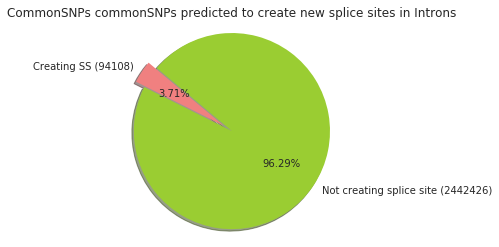

In [41]:
introns_Intersect_SNPs_nonSS = pd.read_csv("../temp/"+whichDataSet+"/Introns_Intersect_"+whichDataSet+"_NotWithinSS.txt",header=None,sep="\t")
numSNPs_introns_creatingBoth5p3pSS = len([i for i in SNPs_createSS_5p if i in SNPs_createSS_3p])
numSNPs_introns_creatingOnly5pSS = len([i for i in SNPs_createSS_5p if i not in SNPs_createSS_3p])
numSNPs_introns_creatingOnly3pSS = len([i for i in SNPs_createSS_3p if i not in SNPs_createSS_5p])
numSNPs_introns_Notcreating5p3pSS = introns_Intersect_SNPs_nonSS.shape[0] - (numSNPs_introns_creatingBoth5p3pSS + numSNPs_introns_creatingOnly5pSS + numSNPs_introns_creatingOnly3pSS)
labels = 'Creating SS (' + str(numSNPs_introns_creatingOnly5pSS+numSNPs_introns_creatingOnly3pSS+numSNPs_introns_creatingBoth5p3pSS) + ')','Not creating splice site (' + str(numSNPs_introns_Notcreating5p3pSS)+')'
sizes = [numSNPs_introns_creatingOnly5pSS+numSNPs_introns_creatingOnly3pSS+numSNPs_introns_creatingBoth5p3pSS,numSNPs_introns_Notcreating5p3pSS]
colors = ['lightcoral','yellowgreen']
explode = (0.1, 0)  # explode 1st slice
 
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.2f%%', shadow=True, startangle=140)
plt.title(whichDataSet+' commonSNPs predicted to create new splice sites in Introns')
plt.axis('equal')
plt.show()

In [42]:
# Lets write all the SNPs predicted to create new splice sites in files
SNPs_createSS = list(set(SNPs_createSS_5p+SNPs_createSS_3p))
introns_Intersect_SNPs_createSS = introns_Intersect_SNPs_nonSS[introns_Intersect_SNPs_nonSS[9].isin(SNPs_createSS)]
print introns_Intersect_SNPs_createSS.shape
introns_Intersect_SNPs_createSS.to_csv("../temp/"+whichDataSet+"/Introns_Intersect_"+whichDataSet+"_CreateSS.txt",sep="\t",header=False,index=False)
introns_Intersect_SNPs_createSS.head()

(94108, 13)


,0,1,2,3,4,5,6,7,8,9,10,11,12
10,chr1,926013,930154,NM_152486,+,SAMD11,chr1,928120,928121,rs28649395,T,C,0.08187
25,chr1,926013,930154,NM_152486,+,SAMD11,chr1,928175,928176,rs7410998,G,A,0.91010
127,chr1,1020373,1022200,NM_001305275,+,AGRN,chr1,1021471,1021472,rs9777931,C,T,0.52600
129,chr1,1022462,1035276,NM_198576,+,AGRN,chr1,1030683,1030684,rs111203427,T,C,0.79250
130,chr1,1022462,1035276,NM_001305275,+,AGRN,chr1,1028564,1028565,rs113632379,T,C,0.06030


In [43]:
# Lets write all the SNPs that are not predicted to create new splice sites in files
introns_Intersect_SNPs_DoesNotcreateSS = introns_Intersect_SNPs_nonSS[~introns_Intersect_SNPs_nonSS[9].isin(SNPs_createSS)]
print introns_Intersect_SNPs_DoesNotcreateSS.shape
introns_Intersect_SNPs_DoesNotcreateSS.to_csv("../temp/"+whichDataSet+"/Introns_Intersect_"+whichDataSet+"_DoesNotCreateSS.txt",sep="\t",header=False,index=False)
introns_Intersect_SNPs_DoesNotcreateSS.head()

(2442426, 13)


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,chr1,926013,930154,NM_152486,+,SAMD11,chr1,927302,927303,rs115239915,G,A,0.05351
1,chr1,926013,930154,NM_152486,+,SAMD11,chr1,926427,926428,rs13302982,A,G,0.68230
2,chr1,926013,930154,NM_152486,+,SAMD11,chr1,926743,926744,rs13303101,A,G,0.68270
3,chr1,926013,930154,NM_152486,+,SAMD11,chr1,928621,928622,rs1806501,G,C,0.16170
4,chr1,926013,930154,NM_152486,+,SAMD11,chr1,929557,929558,rs2340587,G,A,0.51260


In [44]:
# Lets write the SNPs themselves into a separate file
introns_Intersect_SNPs_DoesNotcreateSS.iloc[:,[6,7,8,9,10,11,12,4]].to_csv("../temp/"+whichDataSet+"/"+whichDataSet+"_Intersect_Introns_DoesNotCreateSS.txt",sep="\t",header=False,index=False)

### We want to look for Category 3 and Category 4 of DAVs: common SNPs that destroy ISREs and ones that result in new ISRE motifs being created.

Look at all common SNPs that are not predicted to create splice sites and identify ones that result in new ISRE motifs or destroy new ISRE motifs

In [5]:
# This is a function that will find mutations that will create or destroy ISRE motifs
def getMutationsThatCreateOrDestroyISREMotifs(ISREfile, mutation_seqfile, mutationsOfInterest, mutsite, create):
    # Open the file containing ISRE motifs
    ISRE_motifs = pd.read_csv(ISREfile,header=None)
    print ISRE_motifs.head()
    # Open file with mutations and sequences surrounding mutations
    mutations_withSeq = pd.read_csv(mutation_seqfile,sep="\t",header=None)
    print mutations_withSeq.shape
    # Open file that contains IDs of mutations of interest
    muts_Of_interest = pd.read_csv(mutationsOfInterest,sep="\t",header=None)
    print muts_Of_interest.shape
    
    # Subset muations_withSeq data and only have ones that contains IDs of mutations of interest
    muts_Of_interest_withSeq = mutations_withSeq[mutations_withSeq[9].isin(muts_Of_interest[9])]
    print muts_Of_interest_withSeq.shape
    
    if create == True:
        index_for_seq = 14
    else:
        index_for_seq = 13
    
    # Create a dictionary that stores the mutated sequence as values with mutation id as the key
    muts_dict = pd.Series(muts_Of_interest_withSeq[index_for_seq].values,index=muts_Of_interest_withSeq[9].values).to_dict()
    
    # These are the lists that are going to contain the mutation ids for mutations that result in new ISRE motifs
    mutations_Have_Motifs = []

    # Go through every record in mutation file
    for mut in muts_dict.keys():
        mut_seq = muts_dict[mut]
        mutatedISREmotifs_for_mut = []
        for i in ISRE_motifs[0].values:
            x = [[m.start(), m.end()] for m in re2.finditer(i, mut_seq,overlapped=True) if mutsite in range(m.start(), m.end())]
            if len(x) != 0:
                mutatedISREmotifs_for_mut.append(i)
        if len(mutatedISREmotifs_for_mut) > 0:
            mutations_Have_Motifs.append([mut,mutatedISREmotifs_for_mut])

    return mutations_Have_Motifs

In [53]:
# This is a function that will find mutations that will create or destroy ISRE motifs
def getMutationsThatCreateOrDestroyISREMotifs_Modify(ISREfile, mutation_seqfile, mutationsOfInterest, mutsite, create):
    # Open the file containing ISRE motifs
    ISRE_motifs = pd.read_csv(ISREfile,header=None)
    print ISRE_motifs.head()
    # Open file with mutations and sequences surrounding mutations
    mutations_withSeq = pd.read_csv(mutation_seqfile,sep="\t",header=None)
    print mutations_withSeq.shape
    # Open file that contains IDs of mutations of interest
    muts_Of_interest = pd.read_csv(mutationsOfInterest,sep="\t",header=None)
    print muts_Of_interest.shape
    
    # Subset muations_withSeq data and only have ones that contains IDs of mutations of interest
    muts_Of_interest_withSeq = mutations_withSeq[mutations_withSeq[9].isin(muts_Of_interest[9])]
    print muts_Of_interest_withSeq.shape
    
    if create == True:
        index_for_seq = 14
    else:
        index_for_seq = 13
    
    # We just want to grab the 10 base pair sequence around the mutant since we want to check if
    # WT base or mutant base is within the 6 base pair ISRE
    muts_Seq_JustAroundMut = muts_Of_interest_withSeq[index_for_seq].str.slice(mutsite-5,mutsite+6)
    
    # These are the dictionary that are going to contain the mutation ids for mutations that result in new ISRE motifs
    # as the keys and the values will be the motifs found 
    mutations_Have_Motifs = {}
    
    # Go through every ISRE
    for motif in ISRE_motifs[0].values:
        muts_WithMotif = muts_Of_interest_withSeq[muts_Seq_JustAroundMut.str.contains(motif)][9]
        #print muts_WithMotif.shape
        #print muts_WithMotif.head()
        for mut in muts_WithMotif.values:
            mutations_Have_Motifs[mut] = mutations_Have_Motifs.get(mut,[])+[motif]

    return mutations_Have_Motifs

In [50]:
# Look for ISRE motifs in the sequences around the SNP that contain the minor allele and check if the minor allele
# is within the ISRE motif found
SNPs_Create_New_ISREs = getMutationsThatCreateOrDestroyISREMotifs_Modify("../data/ISE_ISS_ZWpaper.tsv","../temp/"+whichDataSet+"/Introns_Intersect_"+whichDataSet+"_NotWithinSS-25bp_WTandMUTsequences.txt","../temp/"+whichDataSet+"/Introns_Intersect_"+whichDataSet+"_DoesNotCreateSS.txt",25,True)
print len(SNPs_Create_New_ISREs.keys())

        0
0  ACATGA
1  GTAACG
2  ACATGG
3  GGAACC
4  AGATAG
(2536534, 15)
(2442426, 13)
(2442426, 15)
(5392,)
(1164,)
(6142,)
(2104,)
(4437,)
(3553,)
(4789,)
(4002,)
(4966,)
(4968,)
(4808,)
(2547,)
(5667,)
(1606,)
(2883,)
(5146,)
(2401,)
(5645,)
(6226,)
(1146,)
(4499,)
(3539,)
(2097,)
(2030,)
(3932,)
(4216,)
(2309,)
(7659,)
(4623,)
(3493,)
(3865,)
(2215,)
(4349,)
(3804,)
(3486,)
(5830,)
(3995,)
(4115,)
(3031,)
(3158,)
(3569,)
(1990,)
(3708,)
(4535,)
(3051,)
(2073,)
(3970,)
(4431,)
(5444,)
(4198,)
(3327,)
(4427,)
(5031,)
(6447,)
(3625,)
(2436,)
(3434,)
(6893,)
(3817,)
(6139,)
(5079,)
(1332,)
(3476,)
(5644,)
(3828,)
(3602,)
(4298,)
(4200,)
(5557,)
(3843,)
(4268,)
(1845,)
(3208,)
(3608,)
(6501,)
(3101,)
(2339,)
(5211,)
(3555,)
(4300,)
(2307,)
(6203,)
(4716,)
(5209,)
(3634,)
(4739,)
(4427,)
(4380,)
(3363,)
(2621,)
(4682,)
(2943,)
(3633,)
(4275,)
(3098,)
(3151,)
(4687,)
(4197,)
(6267,)
(4694,)
(2521,)
(4280,)
(2027,)
(3611,)
(3396,)
(2623,)
(4882,)
(3192,)
(4335,)
(3458,)
(7083,)
(5172,)
(2

In [54]:
# Look for ISRE motifs in the sequences around the SNP that contain the major allele and check if the major allele
# is within the ISRE motif found
SNPs_Destroy_ISREs = getMutationsThatCreateOrDestroyISREMotifs_Modify("../data/ISE_ISS_ZWpaper.tsv","../temp/"+whichDataSet+"/Introns_Intersect_"+whichDataSet+"_NotWithinSS-25bp_WTandMUTsequences.txt","../temp/"+whichDataSet+"/Introns_Intersect_"+whichDataSet+"_DoesNotCreateSS.txt",25,False)
print len(SNPs_Destroy_ISREs.keys())

        0
0  ACATGA
1  GTAACG
2  ACATGG
3  GGAACC
4  AGATAG
(2536534, 15)
(2442426, 13)
(2442426, 15)
385080


(2442426, 13)
Here


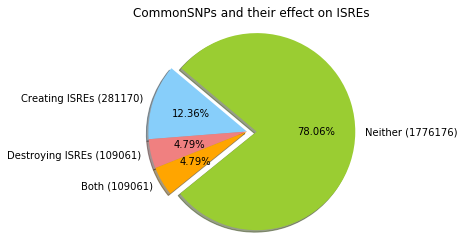

In [58]:
# Piechart to show how DAVs addect ISRE motifs
introns_Intersect_SNPs_DoesNotcreateSS = pd.read_csv("../temp/"+whichDataSet+"/Introns_Intersect_"+whichDataSet+"_DoesNotCreateSS.txt",sep="\t",header=None)
print introns_Intersect_SNPs_DoesNotcreateSS.shape
SNPs_NotcreatingdestroyingISREs = introns_Intersect_SNPs_DoesNotcreateSS[~introns_Intersect_SNPs_DoesNotcreateSS[9].isin(SNPs_Create_New_ISREs.keys()+SNPs_Destroy_ISREs.keys())][9].values
print "Here"
SNPs_BothcreatingdestroyingISREs = pd.Series(SNPs_Create_New_ISREs.keys())[pd.Series(SNPs_Create_New_ISREs.keys()).isin(pd.Series(SNPs_Destroy_ISREs.keys()))].values
SNPs_JustcreatingISREs = pd.Series(SNPs_Create_New_ISREs.keys())[~pd.Series(SNPs_Create_New_ISREs.keys()).isin(pd.Series(SNPs_Destroy_ISREs.keys()))].values
SNPs_JustdestroyingISREs = pd.Series(SNPs_Destroy_ISREs.keys())[pd.Series(SNPs_Destroy_ISREs.keys()).isin(pd.Series(SNPs_Create_New_ISREs.keys()))].values

labels = 'Creating ISREs (' + str(len(SNPs_JustcreatingISREs)) + ')', \
    'Destroying ISREs (' + str(len(SNPs_JustdestroyingISREs))+')', \
    'Both (' + str(len(SNPs_BothcreatingdestroyingISREs))+')', \
    'Neither (' + str(len(SNPs_NotcreatingdestroyingISREs))+')'
sizes = [len(SNPs_JustcreatingISREs),len(SNPs_JustdestroyingISREs),len(SNPs_BothcreatingdestroyingISREs),len(SNPs_NotcreatingdestroyingISREs)]
colors = ['lightskyblue','lightcoral','orange','yellowgreen']
explode = (0, 0,0,0.1)  # explode last slice
 
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.2f%%', shadow=True, startangle=140)
plt.title(whichDataSet+' and their effect on ISREs')
plt.axis('equal')
plt.show()

In [59]:
# We want to write these mutations into files 
introns_Intersect_SNPs_DoesNotcreateSS[introns_Intersect_SNPs_DoesNotcreateSS[9].isin(SNPs_BothcreatingdestroyingISREs)].to_csv("../temp/"+whichDataSet+"/Introns_Intersect_"+whichDataSet+"_BothCreateDestroyISRE.txt",sep="\t",header=False,index=False)
introns_Intersect_SNPs_DoesNotcreateSS[introns_Intersect_SNPs_DoesNotcreateSS[9].isin(SNPs_NotcreatingdestroyingISREs)].to_csv("../temp/"+whichDataSet+"/Introns_Intersect_"+whichDataSet+"_NotCreateDestroyISRE.txt",sep="\t",header=False,index=False)
introns_Intersect_SNPs_DoesNotcreateSS[introns_Intersect_SNPs_DoesNotcreateSS[9].isin(SNPs_JustcreatingISREs)].to_csv("../temp/"+whichDataSet+"/Introns_Intersect_"+whichDataSet+"_JustCreateISRE.txt",sep="\t",header=False,index=False)
introns_Intersect_SNPs_DoesNotcreateSS[introns_Intersect_SNPs_DoesNotcreateSS[9].isin(SNPs_JustdestroyingISREs)].to_csv("../temp/"+whichDataSet+"/Introns_Intersect_"+whichDataSet+"_JustDestroyISRE.txt",sep="\t",header=False,index=False)

In [61]:
# We need to grab just the SNPs that are not creating or destroying ISREs and write that to a file
introns_Intersect_SNPs_DoesNotcreateSS[introns_Intersect_SNPs_DoesNotcreateSS[9].isin(SNPs_NotcreatingdestroyingISREs)].iloc[:,[6,7,8,9,4,10,11,12]].to_csv("../temp/"+whichDataSet+"/"+whichDataSet+"_Intersect_Introns_NotCreateDestroyISRE.txt",sep="\t",index=False,header=False)

### We focus on next category to assign: common SNPs that are found flanking 100bp around ISREs.  

We first intersect the common SNPs with 100bp flanking ISREs. 

Data for 100bp flanking ISREs coordinates comes from script Analyzing distribution of ISREs within introns.ipynb

In [62]:
%%script bash
# Use bedtools to extract sequences around SNPs from fasta file and write both a fasta file and a TSV file
DataSet="CommonSNPs"
echo $DataSet
# Intersect SNPs that are not creating or destroying ISREs with 100bp around ISREs
bedtools intersect -a ../processed_data/ISREs_Intersect_Introns_singleISRElocation_50bpWindow.bed -b ../temp/${DataSet}/${DataSet}_Intersect_Introns_NotCreateDestroyISRE.txt -wa -wb > ../temp/${DataSet}/ISREs_Intersect_${DataSet}_Intersect_Introns.txt


CommonSNPs


In [63]:
# Read in the intersection data
ISREs_Intersect_introns_Intersect_SNPs = pd.read_csv("../temp/"+whichDataSet+"/ISREs_Intersect_"+whichDataSet+"_Intersect_Introns.txt",sep="\t",header=None)
print ISREs_Intersect_introns_Intersect_SNPs.shape
ISREs_Intersect_introns_Intersect_SNPs.head()

(3434185, 13)


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,chr1,929319,929425,GGAACA,+,chr1,929376,929377,rs2340588,+,G,A,0.7887
1,chr1,929276,929382,ATGGGA,+,chr1,929376,929377,rs2340588,+,G,A,0.7887
2,chr1,929311,929417,GGGTTT,+,chr1,929376,929377,rs2340588,+,G,A,0.7887
3,chr1,926642,926748,AGGGAG,+,chr1,926743,926744,rs13303101,+,A,G,0.6827
4,chr1,928049,928155,AGGGAG,+,chr1,928130,928131,rs28626846,+,T,C,0.2728


In [64]:
# Sanity check to see how many SNPs we are intersecting
print ISREs_Intersect_introns_Intersect_SNPs.iloc[:,8].drop_duplicates().shape[0]

905291


In [65]:
# We only want to include SNPs found in introns on the same strand as the ISREs
ISREs_Intersect_introns_Intersect_SNPs_SameStrand = ISREs_Intersect_introns_Intersect_SNPs[ISREs_Intersect_introns_Intersect_SNPs[4]==ISREs_Intersect_introns_Intersect_SNPs[9]]
print ISREs_Intersect_introns_Intersect_SNPs_SameStrand.shape

(3420005, 13)


In [66]:
# Write these SNPs to a file
ISREs_Intersect_introns_Intersect_SNPs_SameStrand.to_csv("../temp/"+whichDataSet+"/"+whichDataSet+"_Flanking_100bpISREs.txt",sep="\t",header=False,index=False)

This is the last category of common SNPs: They don't meet any of the above criteria -> not found in SS, don't create splice sites, not found in ISREs, don't create new ISREs, not flanking 100 bp around ISREs

In [67]:
# Get SNPs that are not found flanking ISREs and don't meet any of above categories
SNPs_NotCreatingDestroyingISREs = pd.read_csv("../temp/"+whichDataSet+"/Introns_Intersect_"+whichDataSet+"_NotCreateDestroyISRE.txt",sep="\t",header=None)
SNPs_NotMeetingAnyCriteria = SNPs_NotCreatingDestroyingISREs[~SNPs_NotCreatingDestroyingISREs[9].isin(ISREs_Intersect_introns_Intersect_SNPs_SameStrand[8])]
print SNPs_NotMeetingAnyCriteria.shape
SNPs_NotMeetingAnyCriteria.head()

(871362, 13)


,0,1,2,3,4,5,6,7,8,9,10,11,12
4,chr1,926013,930154,NM_152486,+,SAMD11,chr1,928260,928261,rs28569249,G,A,0.28120
6,chr1,926013,930154,NM_152486,+,SAMD11,chr1,928263,928264,rs28739566,T,C,0.29890
10,chr1,926013,930154,NM_152486,+,SAMD11,chr1,928482,928483,rs35854196,G,A,0.25240
11,chr1,926013,930154,NM_152486,+,SAMD11,chr1,927485,927486,rs3892970,C,T,0.47660
13,chr1,926013,930154,NM_152486,+,SAMD11,chr1,928209,928210,rs61769724,G,A,0.05491


In [68]:
SNPs_NotMeetingAnyCriteria.to_csv("../temp/"+whichDataSet+"/Introns_Intersect_"+whichDataSet+"_DoNotMeetAnyCriteria.txt",sep="\t",header=False,index=False)

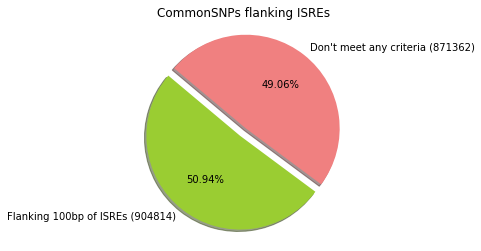

In [69]:
labels = "Flanking 100bp of ISREs (" + str(ISREs_Intersect_introns_Intersect_SNPs_SameStrand[8].drop_duplicates().shape[0]) +')', \
"Don't meet any criteria (" + str(SNPs_NotMeetingAnyCriteria[9].drop_duplicates().shape[0]) + ')'
sizes = [ISREs_Intersect_introns_Intersect_SNPs_SameStrand[8].drop_duplicates().shape[0], \
         SNPs_NotMeetingAnyCriteria[9].drop_duplicates().shape[0]]
colors = ['yellowgreen','lightcoral',]
explode = (0.1,0)  # explode 1st slice
 
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.2f%%', shadow=True, startangle=140)
plt.title('CommonSNPs flanking ISREs')
plt.axis('equal')
plt.show()

## We are also going to see how much common SNPs alter the base pairing distance around them 

In [6]:
numBasesToFold = 100

In [8]:
# First we have to grab the coordinates +/- 100 base pairs of these SNPs and write to file. 
SNPs = pd.read_table("../temp/"+whichDataSet+"/"+whichDataSet+"_Flanking_100bpISREs.txt",sep="\t",header=None)
print SNPs.head()
SNPs_newdata = {"chrm":SNPs[5],"start":SNPs[6]-(numBasesToFold/2),"end":SNPs[7]+(numBasesToFold/2),"snp_id":SNPs[8],"strand":SNPs[9],"score":[0]*len(SNPs[8])}
SNPs_newdf = pd.DataFrame(SNPs_newdata,columns=["chrm","start","end","snp_id","score","strand"]).drop_duplicates()
print SNPs_newdf.head()
SNPs_newdf.to_csv("../temp/"+whichDataSet+"/"+whichDataSet+"_Flanking_100bpISREs_" + str(numBasesToFold) + "bpwindow.txt",header=False,index=False,sep="\t")

     0       1       2       3  4     5       6       7           8  9  10 11  \
0  chr1  929319  929425  GGAACA  +  chr1  929376  929377   rs2340588  +  G  A   
1  chr1  929276  929382  ATGGGA  +  chr1  929376  929377   rs2340588  +  G  A   
2  chr1  929311  929417  GGGTTT  +  chr1  929376  929377   rs2340588  +  G  A   
3  chr1  926642  926748  AGGGAG  +  chr1  926743  926744  rs13303101  +  A  G   
4  chr1  928049  928155  AGGGAG  +  chr1  928130  928131  rs28626846  +  T  C   

       12  
0  0.7887  
1  0.7887  
2  0.7887  
3  0.6827  
4  0.2728  
   chrm   start     end      snp_id  score strand
0  chr1  929326  929427   rs2340588      0      +
3  chr1  926693  926794  rs13303101      0      +
4  chr1  928080  928181  rs28626846      0      +
5  chr1  928077  928178   rs7410984      0      +
6  chr1  926199  926300   rs2879816      0      +


In [9]:
%%script bash
numbases=100
DataSet="CommonSNPs"
# Get the sequences for that file 
bedtools getfasta -fi /home/shared/hg38/hg38.fa -bed ../temp/${DataSet}/${DataSet}_Flanking_100bpISREs_${numbases}bpwindow.txt -name -s -tab -fo ../temp/${DataSet}/${DataSet}_Flanking_100bpISREs_${numbases}bpwindow-Sequences.txt

In [10]:
import subprocess
# This function will run SNPfold on every mutation and write a file that contains the results with the mutation information
# It requires a file that contains sequences around mutation, a file containing info of the WT base and MUT base
def runSNPFold(mutseqfile, mutfile, baseOfinterest,writefile):
    
    # Read the file containing sequences around mutation
    mutseqfile = pd.read_table(mutseqfile,sep="\t",header=None)
    # Create a dictionary for those sequences using the mutation id as key
    mutseq_dict = pd.Series(mutseqfile[1].values,index=mutseqfile[0].values).to_dict()
    
    # Read the file containing information about WT base and MUT base
    mutfile = pd.read_table(mutfile,sep="\t",header=None).iloc[:,range(5,13)].drop_duplicates()
    print mutfile.head()
    # Create a dictionary for strand, WT base and MUT base using the mutation id as key
    mut_dict = {row[8]:[row[9],row[10],row[11]] for index, row in mutfile.iterrows()} 
    #pd.Series(mutfile.iloc[:,[4,5,6]].values,index=mutfile[8].values).to_dict()

    # Dictionary for complementary base dictionary
    base_dict = {'A': 'T', 'T': 'A', 'G': 'C', 'C': 'G'}
    
    # Go through every mutation and run SNPFold on it, the accurate version and write results to file
    with open(writefile, "w") as fw:
        # First write header
        fw.write("MUT" + "\t" + "CC_BPPROB" + "\t" + "CC_BPPROB_PVAL" + "\t" + "CC_SHANNON" + "\t" + "CC_SHANNON_PVAL")
        fw.write("\n")
        # Go through every mutation
        for mut in mut_dict.keys():
            # Get the sequence and bases for the mutation
            seq4mut = mutseq_dict[mut]
            bases4mut = mut_dict[mut]
            # If the mutation is on the negative strand, get the complement of the WT and MUT base
            # Else just get the WT and MUT base
            if bases4mut[0]=="-":
                WTbase=base_dict[bases4mut[1]]
                MUTbase=base_dict[bases4mut[2]]
            else:
                WTbase=bases4mut[1]
                MUTbase=bases4mut[2]
            # Call SNP fold and write result into file    
            pipe_out = subprocess.check_output(["SNPfold_commandline.py","-m","all","-n",mut,"-A", seq4mut, WTbase + baseOfinterest + MUTbase])
            snpfold_for_mut = [i.split('\t') for i in pipe_out.strip().split('\n')][1]
            fw.write(mut + "\t" + "\t".join(snpfold_for_mut[1:]))
            fw.write("\n")

In [ ]:
# Run function 
#runSNPFold("../temp/"+whichDataSet+"/"+whichDataSet+"_Flanking_100bpISREs_"+str(numBasesToFold)+"bpwindow-Sequences.txt","../temp/"+whichDataSet+"/"+whichDataSet+"_Flanking_100bpISREs.txt",str((numBasesToFold/2)+1),"../temp/"+whichDataSet+"/"+whichDataSet+"_Flanking_100bpISREs_"+str(numBasesToFold)+"bpwindow_SNPFoldResults.txt")